In [1]:
#coding=utf-8
# ------------------------------------------------------------------------------------------#
# 
#-------------------------------------------------------------------------------------------#
from netCDF4 import Dataset as ncfile
from netCDF4 import num2date, date2num
import datetime
import numpy as np
import numpy.ma as ma
import math
import matplotlib.dates as dates
from pyproj import Proj, transform
import scipy
from scipy import spatial
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Find nearest neighbor point index
def do_kdtree(combined_x_y_arrays,points):
        mytree = scipy.spatial.cKDTree(combined_x_y_arrays)
        dist, indexes = mytree.query(points)
        return indexes
    
# projection of the grid -> era5 on to modis       
def remapfield(MODvar,idx_pos_ij):
    MODprojvar=np.zeros(np.shape(idx_pos_ij))
    for i in range(np.shape(idx_pos_ij)[0]):
        for j in range(np.shape(idx_pos_ij)[1]):
            MODprojvar[i][j]=MODvar[idx_pos_ij[i][j]]
    return MODprojvar

class SpatialEvaluation:
    
    def __init__(self,modeleval):
        self.model=modeleval
    
    def defineGridTransforms(self):
        
        #MODIS grid (same as AROME Arctic)      
        modisin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
        AROMEin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/04/arome_arctic_det_2_5km_20240404T00Z.nc'
        #
        modisdataset = ncfile(modisin, 'r')     
        aromedataset = ncfile(AROMEin, 'r') # not sufficient information in modis file
        modis_lons = aromedataset.variables['longitude'][:,:]
        modis_lats = aromedataset.variables['latitude'][:,:]
        modis_x = aromedataset.variables['x'][:]
        modis_y = aromedataset.variables['y'][:]
        modis_times = modisdataset.variables['time'][:]
        t_unit = modisdataset.variables['time'].units
        modis_nctimes=[]; modis_nctimes.append(num2date(modis_times,units = t_unit,calendar = 'proleptic_gregorian'))
        modis_nctimes=np.squeeze(modis_nctimes)
        modis_nctimenum = np.squeeze(dates.date2num(modis_nctimes))        
        #
        modis_proj = Proj("+proj=lcc +lat_1=77.5 +lat_2=77.5 +lat_0=77.5 +lon_0=-25 +R=6371000")          
        modisdataset.close()
        aromedataset.close()
            
            
        if self.model=='ECMWF-IFS': 
            # ----- IFS Grid information
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/'
            MODin = fc_data_path+'Arctic.ECMWF_extracted_20240401T00Z.nc'
            #
            MODdataset = ncfile(MODin, 'r')
            MOD_lons = MODdataset.variables['lon'][:]
            MOD_lats = MODdataset.variables['lat'][:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
            #
            MOD_proj = Proj(init = 'epsg:4326')
            MODdataset.close()

        
        MOD_llon, MOD_llat = np.meshgrid(MOD_lons,MOD_lats)
        modis_xx, modis_yy   = np.meshgrid(modis_x, modis_y)

        # Project all on MODIS grid
        MOD_xx,MOD_yy = transform(MOD_proj, modis_proj, MOD_llon, MOD_llat)

        # Vectorize and concatenate the x,y coordinates
        modis_xx_yy = np.dstack([modis_xx.ravel(), modis_yy.ravel()])[0]
        MOD_xx_yy  = np.dstack([MOD_xx.ravel(), MOD_yy.ravel()])[0]

        #idx_pos = do_kdtree(modis_xx_yy, era5_xx_yy)     #Gives a field with dimensions of era5_xx_yy
        idx_pos = do_kdtree( MOD_xx_yy, modis_xx_yy)     #Gives a field with dimensions of modis_xx_yy

        idx_pos_ij = idx_pos.reshape(np.shape(modis_xx))  #Gives a field with dimensions of modis_xx    

        self.idx_pos_ij = idx_pos_ij
        
        self.modis_lons=modis_lons
        self.modis_lats=modis_lats
        self.modis_nctimes=modis_nctimes
        self.modis_nctimenum=modis_nctimenum
        
        
    def ModelTransform(self,filein,timestep,variable):
    
        if self.model=='ECMWF-IFS': 
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/' 
            MODin = fc_data_path+filein
            #
            MODdataset = ncfile(MODin, 'r')
            MODdata    = MODdataset[variable][timestep,:,:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimes   = np.squeeze(MOD_nctimes)
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
        
               
        MODdataset.close()
               
        self.MODnctimes   = MOD_nctimes[timestep]
        self.MODnctimenum = MOD_nctimenum[timestep]
        self.MODprojdata  = remapfield(MODdata.ravel(),self.idx_pos_ij)
        
        
    def DiffToMODIS(self):
    
        #MODIS grid (same as AROME Arctic)      
        modisin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
    
        modisdataset = ncfile(modisin, 'r')   
        
        tm = np.argmin(np.abs(self.MODnctimenum-self.modis_nctimenum))
        
        print('Model date:',self.MODnctimes)
        print('MODIS date:',self.modis_nctimes[tm])
             
        tempmodis = modisdataset['modis_sist'][tm,:,:] 
        
        self.modisdata = tempmodis
        
        modisdataset.close()
         


### Do Calculations in the right Order

In [42]:
m1 = SpatialEvaluation(modeleval='ECMWF-IFS')
m1.defineGridTransforms()

m1.ModelTransform(filein = 'Arctic.ECMWF_extracted_20240405T00Z.nc',timestep=19,variable='SKT')
m1.DiffToMODIS()
m1.MaskOceanValues()



Model date: 2024-04-05 19:00:00
MODIS date: 2024-04-05 19:00:00


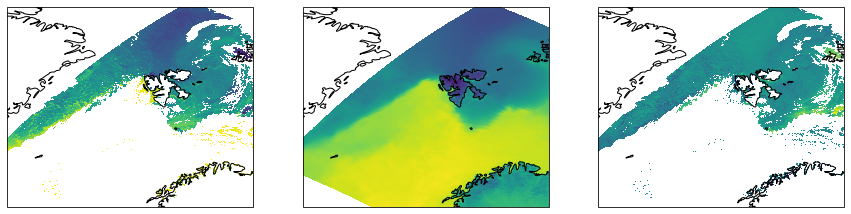

In [43]:
plot_proj = ccrs.Orthographic(14,25)
fig, ax = plt.subplots(figsize=(15, 7),nrows=1,ncols=3,subplot_kw={'projection': plot_proj})

ax[0].coastlines(resolution='50m')
ax[0].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[0].pcolormesh(m1.modis_lons, m1.modis_lats, m1.modisdata, transform=ccrs.PlateCarree())

ax[1].coastlines(resolution='50m')
ax[1].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[1].pcolormesh(m1.modis_lons, m1.modis_lats, m1.MODprojdata, transform=ccrs.PlateCarree())

ax[2].coastlines(resolution='50m')
ax[2].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[2].pcolormesh(m1.modis_lons, m1.modis_lats, m1.MODprojdata-m1.modisdata , transform=ccrs.PlateCarree())

In [ ]:
#TODO: MASK SIC



In [44]:
np.nanmean(m1.MODprojdata-m1.modisdata)

5.393263488538475